In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 24 00:21:41 2018

@author: aditya.sharma & james.macdonald
"""

# In[1]:


import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
import datetime as dt
from datetime import timedelta
import random
import pandas as pd

tf.__version__

/Users/jmacdonald/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/jmacdonald/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.8.0'

In [2]:
class DataSet(object):
    # Set up a dataset object to simplify handling the data
    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._index_in_epoch = 0
        self._epochs_done = 0
        self._cls = cls

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]

In [3]:
def load_data(input_path, dataset_type, image_size):
    # Load the data into a datset object for easy management
    images = []
    labels = []
    img_names = []
    cls = []
    data_path = os.path.join(input_path, str(dataset_type+'-set'))
    label_path = os.path.join(input_path, str(dataset_type+'.txt'))
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()
        random.shuffle(lines) # Shuffle at load to ensure randomization
        for line in lines:
            filename, index = line.split(' ')
            label = np.zeros(62)
            label[int(index)] = 1.0
            labels.append(label)
            img_names.append(filename)
            image_file_path = os.path.join(data_path, filename)
            image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            image = np.reshape(image, image_size*image_size)
            images.append(image)
            cls.append(int(index))
    images = np.array(images)
    labels = np.array(labels)
    img_names = np.array(img_names)
    cls = np.array(cls)
    return DataSet(images, labels, img_names, cls)

Size of:
- Training-set:		37882
- Validation-set:	6262


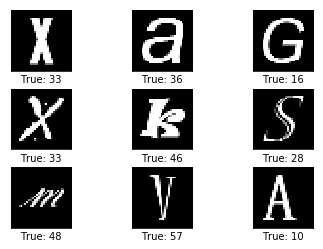

In [4]:
input_path = '../Input/'
num_channels = 1
num_classes = 62
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

train = load_data('../Input/','train',32)
validation = load_data('../Input/','vali',32)

print("Size of:")
print("- Training-set:\t\t{}".format(len(train.labels)))
print("- Validation-set:\t{}".format(len(validation.labels)))


def plot_images(images, cls_true, img_shape=None, cls_pred=None):
    # Plot the images for visibility
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape((img_size,img_size)), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

images = validation.images[0:9]
cls_true = validation.cls[0:9]
plot_images(images=images, cls_true=cls_true)



In [5]:
# Functions to set up the graph, giving flexibility via the use of dictionaries defined later

activation_dictionary = {'relu':tf.nn.relu,'lrelu':tf.nn.leaky_relu,'tanh':tf.nn.tanh,'sigmoid':tf.nn.sigmoid}

def new_weights(shape):
    new_weight = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(new_weight)

def new_biases(length):
    new_bias = tf.constant(0.05, shape=[length])
    return tf.Variable(new_bias)

def new_conv_layer(previous_layer,p):
    if p['maxpool'].lower()=='first':
        previous_layer = tf.nn.max_pool(value=previous_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    weights = new_weights(shape=[p['fSize'], p['fSize'], p['channels'], p['fN']])
    biases = new_biases(length=p['fN'])
    
    layer = tf.nn.conv2d(input=previous_layer, filter=weights, strides=[1, p['sSize'], p['sSize'], 1],
                         padding='SAME')
    layer += biases
    if p['maxpool'].lower()=='last':
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = tf.layers.batch_normalization(layer, training=training, axis=-1)
    activation = activation_dictionary[p['activation']]
    layer = activation(layer)
    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def new_fc_layer(input, params): 
    weights = new_weights(shape=[params['Nfeatures'], params['nodes']])
    biases = new_biases(length=params['nodes'])
    layer = tf.matmul(input, weights) + biases
    layer = tf.layers.batch_normalization(layer, training=training)
    if params['activation'] != 'None':
        activation = activation_dictionary[params['activation']]
        layer = activation(layer)
    layer = tf.nn.dropout(layer, 1-params['dropout'])
    return layer, weights

In [6]:
# Set parameters for CNN layers in a neat, easy-to-manage dictionary
convolution_params = {
    'layer_1a':{'fSize':1,'fN':16,'sSize':1,'activation':'relu','channels':1,'maxpool':'Last'},
    
    'layer_1b1':{'fSize':1,'fN':16,'sSize':1,'activation':'relu','channels':1,'maxpool':'None'},
    'layer_1b2':{'fSize':3,'fN':16,'sSize':1,'activation':'relu','channels':16,'maxpool':'Last'},
    
    'layer_1c1':{'fSize':1,'fN':16,'sSize':1,'activation':'relu','channels':1,'maxpool':'None'},
    'layer_1c2':{'fSize':5,'fN':16,'sSize':1,'activation':'relu','channels':16,'maxpool':'Last'},
    
    'layer_1d':{'fSize':1,'fN':16,'sSize':1,'activation':'relu','channels':1,'maxpool':'First'},
    
    'layer_2a':{'fSize':3,'fN':32,'sSize':1,'activation':'relu','channels':64,'maxpool':'last'},
    'layer_2b':{'fSize':3,'fN':32,'sSize':1,'activation':'relu','channels':64,'maxpool':'last'},
    'layer_2c':{'fSize':3,'fN':32,'sSize':1,'activation':'relu','channels':64,'maxpool':'last'},
    
    'layer_3':{'fSize':3,'fN':128,'sSize':1,'activation':'relu','channels':96,'maxpool':'last'},
    
    'layer_4':{'fSize':3,'fN':256,'sSize':1,'activation':'relu','channels':128,'maxpool':'last'}
}

# Set parameters for Fully Connected layers
fc_params = {
    'layer_1':{'nodes':200,'activation':'relu','dropout':0.2,'batch_norm':'fc1'},
    'layer_2':{'nodes':62,'activation':'None','dropout':0,'batch_norm':'fc2'}
}

#regularization strength
reg_constant = 0.01

In [7]:
#Set up the graph

# 1. define label
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='label')
y_true_class = tf.argmax(y_true, axis=1)

# 2. Define input and training parameter (for batch norm)
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, 1])
training = tf.placeholder(tf.bool)

# 3. Define the first convolutional layer
layer_conv1a, w_c1a = new_conv_layer(previous_layer=x_image, p=convolution_params['layer_1a'])
layer_conv1b, w_c1b1 = new_conv_layer(previous_layer=x_image, p=convolution_params['layer_1b1'])
layer_conv1b, w_c1b2 = new_conv_layer(previous_layer=layer_conv1b, p=convolution_params['layer_1b2'])
layer_conv1c, w_c1c1 = new_conv_layer(previous_layer=x_image, p=convolution_params['layer_1c1'])
layer_conv1c, w_c1c2 = new_conv_layer(previous_layer=layer_conv1c, p=convolution_params['layer_1c2'])
layer_conv1d, w_c1d = new_conv_layer(previous_layer=x_image, p=convolution_params['layer_1d'])

# 4. Define the second convolutional layer
layer_conv1 = tf.concat([layer_conv1a,layer_conv1b,layer_conv1c, layer_conv1d], 3)
layer_conv2a, w_c2a = new_conv_layer(previous_layer=layer_conv1, p=convolution_params['layer_2a']) 
layer_conv2b, w_c2b = new_conv_layer(previous_layer=layer_conv1, p=convolution_params['layer_2b']) 
layer_conv2c, w_c2c = new_conv_layer(previous_layer=layer_conv1, p=convolution_params['layer_2c']) 
layer_conv2 = tf.concat([layer_conv2a,layer_conv2b,layer_conv2c], 3)

# 5. Define the third and fourth convolutional layers
layer_conv3, w_c3 = new_conv_layer(previous_layer=layer_conv2, p=convolution_params['layer_3']) 
layer_conv4, w_c4 = new_conv_layer(previous_layer=layer_conv3, p=convolution_params['layer_4'])

# 6. Define the fully-connected layers
layer_flat, num_features = flatten_layer(layer_conv4)
fc_params['layer_1']['Nfeatures'] = num_features
layer_fc1, w_fc1 = new_fc_layer(input=layer_flat, params=fc_params['layer_1'])
fc_params['layer_2']['Nfeatures'] = fc_params['layer_1']['nodes']
layer_fc2, w_fc2 = new_fc_layer(input=layer_fc1, params=fc_params['layer_2'])

# 7. Define the prediction probabilities and classes
y_hat = tf.nn.softmax(layer_fc2)
y_hat_class = tf.argmax(y_hat, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

# 8. Define the cost and regularization function
cost = tf.reduce_mean(cross_entropy)
weight_store = [w_c1a,w_c1b1,w_c1b2,w_c1c1,w_c1c2,w_c1d,w_c2a,w_c2b,w_c2c,w_c3,w_c4,w_fc1,w_fc2]
regularizers = np.sum([tf.nn.l2_loss(i) for i in weight_store])
cost = tf.reduce_mean(cost + reg_constant * regularizers)

# 9. Define the optimization step and metrics
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_hat_class, y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [8]:
def optimize(num_iterations):

    train_scores = []
    start_time = time.time()

    for i in range(num_iterations):
        
        #Create the training batch, feed to training dictionary and run optimization step
        x_batch, y_true_batch, _, _ = train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch, training:True}
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # record for model assessment and printing progress
        if i % 10 == 0:
            feed_dict_train[training]=False
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            train_scores.append(acc)
            if i % 200 == 0:
                msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
                print(msg.format(i + 1, acc))

    time_dif = time.time() - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    return train_scores

def print_validation_accuracy():
    # Given test data, get the accuracy
    num_validation = len(validation.images)
    cls_pred = np.zeros(shape=num_validation, dtype=np.int)
    i = 0
    feed_dict = {x: validation.images, y_true: validation.labels, training:False}
    cls_pred = session.run(y_hat_class, feed_dict=feed_dict)
    cls_true = validation.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_validation
    msg = "Accuracy on validation-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_validation))
    return acc

In [9]:
# Train the model

train_batch_size = 128
np.random.seed(10)
session = tf.Session()
session.run(tf.global_variables_initializer())

train_scores = optimize(num_iterations=5001)

Optimization Iteration:      1, Training Accuracy:   2.3%
Optimization Iteration:    201, Training Accuracy:  30.5%
Optimization Iteration:    401, Training Accuracy:  71.1%
Optimization Iteration:    601, Training Accuracy:  81.2%
Optimization Iteration:    801, Training Accuracy:  82.0%
Optimization Iteration:   1001, Training Accuracy:  78.9%
Optimization Iteration:   1201, Training Accuracy:  87.5%
Optimization Iteration:   1401, Training Accuracy:  82.8%
Optimization Iteration:   1601, Training Accuracy:  89.8%
Optimization Iteration:   1801, Training Accuracy:  89.1%
Optimization Iteration:   2001, Training Accuracy:  85.9%
Optimization Iteration:   2201, Training Accuracy:  90.6%
Optimization Iteration:   2401, Training Accuracy:  88.3%
Optimization Iteration:   2601, Training Accuracy:  88.3%
Optimization Iteration:   2801, Training Accuracy:  88.3%
Optimization Iteration:   3001, Training Accuracy:  92.2%
Optimization Iteration:   3201, Training Accuracy:  89.1%
Optimization I

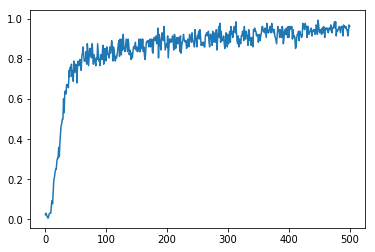

In [10]:
%matplotlib inline
plt.plot(train_scores)

In [11]:
print_validation_accuracy()

Accuracy on validation-Set: 86.9% (5444 / 6262)


0.8693708080485468

In [14]:
try:
    os.makedirs('../models/cnn/cnn_1/')
except:
    None
    
saver = tf.train.Saver(tf.global_variables())
saver.save(session, "../models/cnn/cnn_1/test_final_inception_cnn.ckpt")

'../models/cnn/cnn_1/test_final_inception_cnn.ckpt'

In [58]:
def score_images(dataset,v_batch_size = 500):
    #Function to score a new dataset using the trained model
    index = 0
    scores = np.array([])
    while index < len(dataset.images):
        start = index
        end = index + v_batch_size
        index = end
        if end > len(dataset.images):
            x_in = dataset.images[start:]
        else:
            x_in = dataset.images[start:end]

        feed_dict = {x: x_in, training:False}
        cls_pred = session.run(y_hat_class, feed_dict=feed_dict)
        scores = np.concatenate([scores, cls_pred])
    df = pd.DataFrame(scores.astype(int), index=dataset.img_names, columns=['predict'])
    return df

def save_predictions(predictions):
    # Save the predictions in the appropriate file and folder
    outpath = dt.datetime.now().strftime('../outputs/')
    outfile = outpath+'test.txt'
    os.makedirs(outpath)
    predictions.to_csv(outfile, header=False, sep=" ")